In [1]:
from astropy.table import Table
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import corv
import os

from tqdm import tqdm
from scripts import make_bins

plt.style.use('stefan.mplstyle')

Could not import Koester models. Contact arseneau@bu.edu if these are needed.
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.


In [2]:
spyobjs = pd.read_csv(os.path.join('data', 'reference_objs.csv'))
spyobjs.head()

,Name,GaiaDR2,SPYTeff,SPYlogg,Rem,FileName,RAJ2000,DEJ2000,jul_date,obsname,SOURCE_ID,r_med_geo,GaiaEDR3,TeffH,e_TeffH,loggH,e_loggH
0,EC12489-2750,3495397496775173248,61045,7.63,NaN,EC12489m2750_a_2000_07_13T01_26_13_all.dat.gz,192.921000,-28.113139,2.451739e+06,ec12489m2750_a_2451738_55988057004,3495397496775173248,450.91998,3495397496775173248,NaN,NaN,NaN,NaN
1,EC12489-2750,3495397496775173248,61045,7.63,NaN,EC12489m2750_b_2000_07_15T23_51_15_all.dat.gz,192.921000,-28.113139,2.451741e+06,ec12489m2750_b_2451741_49392732,3495397496775173248,450.91998,3495397496775173248,NaN,NaN,NaN,NaN
2,HE0031-5525,4921390960477978112,11839,7.71,NaN,HE0031m5525_a_2002_07_27T06_08_16_all.dat.gz,8.400417,-55.144139,2.452483e+06,he0031m5525_a_2452482_75575103005,4921390960477978112,67.78850,4921390960477978112,11781.27,156.85,7.912382,0.022214
3,HE0031-5525,4921390960477978112,11839,7.71,NaN,HE0031m5525_b_2001_12_17T00_51_42_all.dat.gz,8.400417,-55.144139,2.452261e+06,he0031m5525_b_2452260_53590983013,4921390960477978112,67.78850,4921390960477978112,11781.27,156.85,7.912382,0.022214
4,HE0032-2744,2343355051714253056,23947,7.81,NaN,HE0032m2744_a_2002_09_15T03_00_04_all.dat.gz,8.657667,-27.472250,2.452533e+06,he0032m2744_a_2452532_62505119015,2343355051714253056,164.07458,2343355051714253056,23414.51,815.16,7.875835,0.058884


In [3]:
data_lines, data_names = np.load('binned-data/linecenters.npy'), np.load('binned-data/names_linecenters.npy')
model_lines, model_names = np.load('binned-data/linecenters_modeltest.npy'), np.load('binned-data/names_linecenters_modeltest.npy')
data_names[0], model_names[0]

(np.str_('ec12489m2750_a_2451738_55988057004'),
 np.str_('ec12489m2750_a_2451738_55988057004'))

In [4]:
observations = Table.read(os.path.join('data', 'radial_velocities', 'nlte_core', 'ab_15aa.csv')).to_pandas().query("7.01 < nlte_logg < 8.99")
observations = observations.query(f"7.01 < nlte_logg < 8.99 & nlte_redchi < 5 & nlte_e_rv < 15")
nltemean, nltestd = observations['nlte_rv'].mean(), observations['nlte_rv'].std()
observations = observations.query("""@nltemean - 3 * @nltestd <= nlte_rv <= @nltemean + 3 * @nltestd""")
np.median(observations.nlte_teff), np.median(observations.nlte_logg)

(np.float64(13999.999243997514), np.float64(7.999999796484607))

In [5]:
def get_windows(i):
    steps = np.linspace(0, 70, 10)
    window = dict(a = 30, b = 30, g = 30, d = 30)
    window['a'] += steps[i]
    window['b'] += steps[i]
    window['g'] += steps[i] * 0.786
    window['d'] += steps[i] * 0.643
    return window

def read_model_spectrum(teff : np.float64, logg : np.float64) -> Tuple[np.array, np.array, np.array]:
    """read a spectrum and return its parameters
    """
    wavl, flux = make_bins.corvmodel.wavl, make_bins.corvmodel.model_spec((teff, logg))
    ivar = 1e4*np.ones(flux.shape[0])
    return (0, teff, logg), wavl, flux, ivar

generate_windows = [70,100,85,75]
windows, centers = [0,1,2,3,4,5,6,7,8,9], {'a':6564.61, 'b':4862.68, 'g':4341.68, 'd':4102.89}
container = {}
for i, (line, center) in enumerate(centers.items()):
    wavl_cutout, flux_cutout, ivar_cutout = make_bins.cutout_line(wavl, flux, ivar, line = line, window = generate_windows[i])
    point, wave = [], []
    for win in windows:
        win_wl = get_windows(win)[line]
        mask = (center - win_wl < wavl_cutout) & (wavl_cutout < center + win_wl) 
        if not ((line == 'a') & (win > 5)):
            point.append(max(flux_cutout[mask]))
            wave.append(win)
    container[line] = np.array([wave, point])


NameError: name 'wavl' is not defined

In [ ]:
names = {'a' : 'H$\\alpha$', 'b' : 'H$\\beta$', 'g' : 'H$\\gamma$', 'd' : 'H$\\delta$'}

interpolate = []
grid = np.linspace(0.5, 1.1, 20)
for name in tqdm(observations.obsname.values):
    try:
        n = np.where((data_names == name))[0][0]
        m = np.where((model_names == name))[0][0]
    except:
        print(name)
        pass
    line_interpolate = []
    for i in range(len(names)):
        interpolated_model = np.interp(grid, model_lines[m,i,2], model_lines[m,i,0])
        interpolated_data = np.interp(grid, data_lines[n,i,2], data_lines[n,i,0])
        line_interpolate.append([interpolated_model, interpolated_data])
    interpolate.append(line_interpolate)
interpolate = np.array(interpolate)

100%|██████████| 778/778 [00:00<00:00, 28765.34it/s]

wd2312-356_2452165_52264577989
wd0956+045_2451946_65619463986
he2356-4513_2452163_6230390002
wd2312-356_2452163_66659044987
wd1141+077_2451920_87891583983
wd1457-086_2451738_6716380599
wd0956+045_2451924_70509159006
wd1457-086_2451741_58511277009
he0219m4049_b_2452165_85925929016
wd0050-332_2452163_65698164981
wd0956+045_2451924_68116327003
wd2359-324_2452799_91318596015
he2159-1649_2451891_52478743019


Text(0, 0.5, 'Normalized Flux')

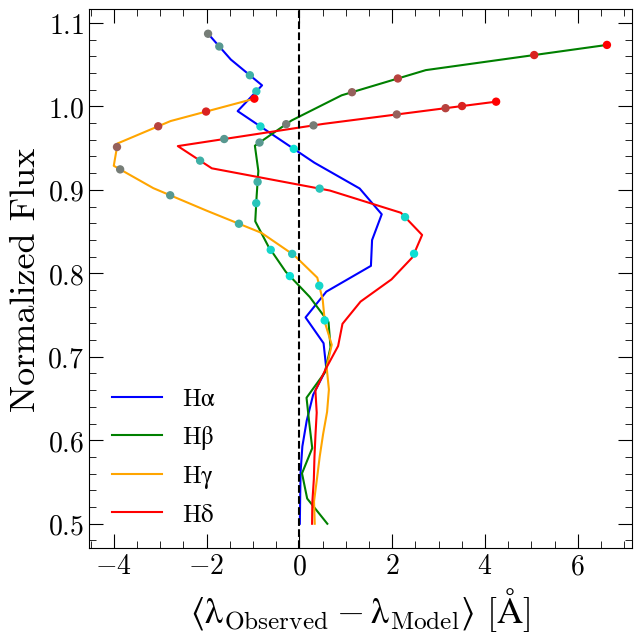

In [ ]:
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.cm import ScalarMappable

axis = np.squeeze(np.nanmedian(interpolate[:,:,1,:] - interpolate[:,:,0,:], axis=0))
colors = {'a' : ['H$\\alpha$', 'blue'], 'b' : ['H$\\beta$', 'green'], 'g' : ['H$\\gamma$', 'orange'], 'd' : ['H$\\delta$', 'red']}

color_vals = np.repeat(np.arange(10), 2)
norm = Normalize(vmin=color_vals.min(), vmax=color_vals.max())
cmap = LinearSegmentedColormap.from_list(
    'bright_blue_red',        # name
    ['#0AE0D4', '#FF0000'],   # endpoints
    N=256,
    gamma=1.4           # <-- key bit: constant V=1 so no black
)

maxima = []
for i, (name, params) in enumerate(colors.items()):
    tmpgrid = np.linspace(min(grid), max(container[name][1]), 20)
    tmparr = np.interp(tmpgrid, grid, axis[i,:])
    wavval = np.interp(container[name][1], tmpgrid, tmparr)

    plt.scatter(wavval, container[name][1], color = cmap(norm(container[name][0])))
    #plt.scatter(axis[i,:], grid, c = color, label = name)
    plt.plot(tmparr, tmpgrid, c = params[1], label=params[0], zorder=0)
plt.axvline(x = 0, c = 'k', zorder=0, ls='--')
plt.legend(framealpha=0)
plt.xlabel(r"$\langle\lambda_\text{Observed} - \lambda_\text{Model}\rangle$ [$\AA$]")
plt.ylabel(r"Normalized Flux")